In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, auc 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
import os
from pathlib import Path
from datetime import datetime
import math

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import json
train_path = Path('/content/drive/MyDrive/Colab Notebooks/Twibot-20/train.json')
val_path = Path('/content/drive/MyDrive/Colab Notebooks/Twibot-20/dev.json')
test_path = Path('/content/drive/MyDrive/Colab Notebooks/Twibot-20/test.json')

with open(train_path, 'r') as f:
    train = json.loads(f.read())
    train = pd.DataFrame(train)

with open(val_path, 'r') as f:
    val = json.loads(f.read())
    val = pd.DataFrame(val)

with open(test_path, 'r') as f:
    test = json.loads(f.read())
    test = pd.DataFrame(test)

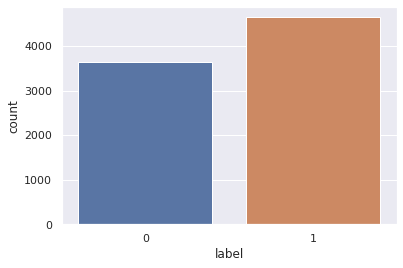

In [ ]:
sns.countplot(x='label', data=train);

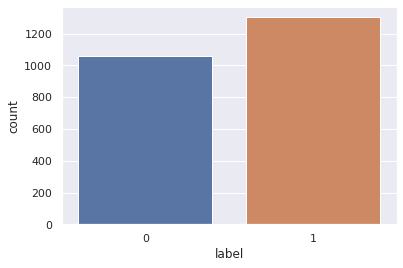

In [ ]:
sns.countplot(x='label', data=val);

In [ ]:
def digits(value):
  cnt = 0
  for i in value:
      if '0' <= i <= '9':
          cnt += 1
  return cnt

def have(value):
  value = value.strip()
  if len(value) == 0:
      return 0
  return 1

def entropy(value):
  value = value.strip()
  p = {}
  for i in value:
      if i not in p:
          p[i] = 0
      p[i] += 1
  for i in p:
      p[i] /= len(value)
  ans = 0
  for i in p:
      ans -= p[i] * math.log(p[i])
  return ans

def calc_age(created_at):
    collect_year = 2020 #dataset collected during
    if created_at is None:
        return 365 * 2

    created_at_str = created_at.to_string()
    created_at_str = created_at_str.strip()

    mode = '%a %b %d %H:%M:%S %z %Y'
    if created_at_str.find('L') != -1:
        created_time = datetime.fromtimestamp(int(created_at.replace('000L', '')))
    else:
        created_time = datetime.strptime(created_at, mode)
    collect_time = datetime.strptime('{} Dec 31'.format(collect_year), '%Y %b %d')
    created_time = created_time.replace(tzinfo=None)
    collect_time = collect_time.replace(tzinfo=None)
    difference = collect_time - created_time
    return difference.days
  
def get_count(row, feature_name):
  if row[feature_name] is None:
    return 0
  else:
    return int(row[feature_name])

def get_bool_as_int(row, feature_name):
  return int(row[feature_name] == 'True ')

def get_length(row, feature_name):
  return len(row[feature_name].strip())

def get_digits(row, feature_name):
  return digits(row[feature_name])

def get_have(row, feature_name):
  return have(row[feature_name])

def get_entropy(row, feature_name):
  return entropy(row[feature_name])

def get_features(data):
  features = pd.DataFrame()
  profile = data['profile']
  features['profile_image_present'] = profile.apply(lambda x: (int(x['profile_image_url'].find('default_profile_normal') == -1)))
  features['listed'] = profile.apply(get_count, feature_name='listed_count')
  features['followers'] = profile.apply(get_count, feature_name='followers_count')
  features['tweets'] = profile.apply(get_count, feature_name='statuses_count')
  features['friends'] = profile.apply(get_count, feature_name='friends_count')
  features['favourites'] = profile.apply(get_count, feature_name='favourites_count') #TBR
  features['verified'] = profile.apply(get_bool_as_int, feature_name='verified') 
  features['screen_name_length'] = profile.apply(get_length, feature_name='screen_name')
  features['name_length'] = profile.apply(get_length, feature_name='name')
  features['screen_name_digits'] = profile.apply(get_digits, feature_name ='screen_name') #TBR
  features['name_digits'] = profile.apply(get_digits, feature_name ='screen_name')
  features['desc_length'] = profile.apply(get_length, feature_name='description') #TBR
  features['location_present'] = profile.apply(get_have, feature_name='location') 
  features['name_entropy'] = profile.apply(get_entropy, feature_name='name')
  features['screen_name_entropy'] = profile.apply(get_entropy, feature_name='screen_name')
  features['desc_entropy'] = profile.apply(get_entropy, feature_name='description')
  features['desc_digits'] = profile.apply(get_digits, feature_name ='description')
  features['default_profile'] = profile.apply(get_bool_as_int, feature_name='default_profile') 
  features['label'] = data['label'].astype(int)
  features['id'] = data['ID'].astype(int)

  return features

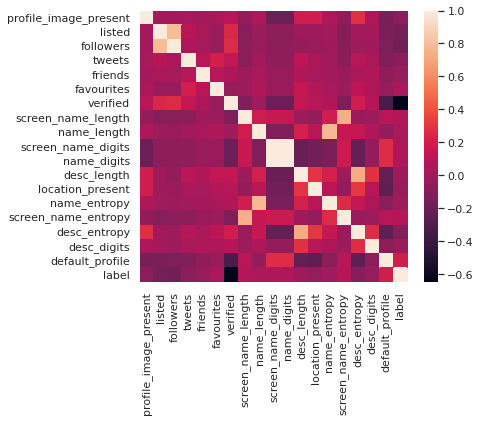

profile_image_present    0.024427
listed                   1.000000
followers                0.787433
tweets                   0.107085
friends                  0.048774
favourites              -0.015574
verified                 0.246405
screen_name_length      -0.086588
name_length             -0.010281
screen_name_digits      -0.058602
name_digits             -0.058602
desc_length             -0.003142
location_present        -0.000545
name_entropy             0.009137
screen_name_entropy     -0.091104
desc_entropy             0.015847
desc_digits              0.014521
default_profile         -0.128935
label                   -0.159058
Name: listed, dtype: float64

In [ ]:
import xgboost
from re import X
train_set = get_features(train)
val_set = get_features(val)
test_set = get_features(test)
del train_set['id']
del val_set['id']
del test_set['id']
corr_matrix = train_set.corr()
fig, ax = plt.subplots(figsize=(6,5))   
sns.heatmap(corr_matrix, xticklabels=True, yticklabels=True)
plt.show()
corr_matrix['label']
train_label = train_set['label'].values
del train_set['label']
val_label = val_set['label'].values
del val_set['label']
test_label = test_set['label'].values
del test_set['label']
corr_matrix['listed']

In [ ]:
#train_set = train_set.values
#val_set = val_set.values
import sklearn.metrics

def train_predict(model):
  model.fit(train_set, train_label)

  y_hat = model.predict(val_set)
  y_hat = y_hat.astype(int)

  y_hat_test = model.predict(test_set)
  y_hat_test = y_hat_test.astype(int)

  acc = sklearn.metrics.accuracy_score(val_label, y_hat)
  precision = sklearn.metrics.precision_score(val_label, y_hat)
  f1_score = sklearn.metrics.f1_score(val_label, y_hat)
  y_hat_proba =  model.predict_proba(val_set)
  auc = sklearn.metrics.roc_auc_score(val_label, y_hat_proba[:,1])
  recall = sklearn.metrics.recall_score(val_label, y_hat)

  acc_test = sklearn.metrics.accuracy_score(test_label, y_hat_test)
  precision_test = sklearn.metrics.precision_score(test_label, y_hat_test)
  f1_score_test = sklearn.metrics.f1_score(test_label, y_hat_test)
  y_hat_test_proba =  model.predict_proba(test_set)
  auc_test = sklearn.metrics.roc_auc_score(test_label, y_hat_test_proba[:,1])
  recall_test = sklearn.metrics.recall_score(test_label, y_hat_test)

  # print(acc, file=f)
  # print(precision, file=f)
  # print(recall, file=f)
  # print(f1_score, file=f)
  # print(auc, dataset, end='\n\n', file=f)
  final = []
  final.append(acc)
  final.append(precision)
  final.append(recall)
  final.append(f1_score)
  final.append(auc)
  final.append(acc_test)
  final.append(precision_test)
  final.append(recall_test)
  final.append(f1_score_test)
  final.append(auc_test)
  df = pd.DataFrame(final, index=['Val Accuracy', 'Val Precision', 'Val Recall', 'Val f1_score', 'Val AUC', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test f1_score', 'Test AUC'], columns = ['Value'])
  print(df)

In [ ]:
print("Model: XGB")
xgb = XGBClassifier(random_state=42, use_label_encoder=False, scale_pos_weight = 2.5, n_estimators = 100, max_depth = 7, subsample = 0.9, colsample_bytree = 1, min_child_weight = 1)
train_predict(xgb)

Model: XGB
                   Value
Val Accuracy    0.798732
Val Precision   0.738604
Val Recall      0.982348
Val f1_score    0.843215
Val AUC         0.839041
Test Accuracy   0.815723
Test Precision  0.750594
Test Recall     0.987500
Test f1_score   0.852901
Test AUC        0.854826


In [ ]:
print("Model: Adaboost")
ada = AdaBoostClassifier(random_state=42, n_estimators=250)
train_predict(ada)

Model: Adaboost
                   Value
Val Accuracy    0.795349
Val Precision   0.742451
Val Recall      0.962394
Val f1_score    0.838235
Val AUC         0.832796
Test Accuracy   0.816568
Test Precision  0.760148
Test Recall     0.965625
Test f1_score   0.850654
Test AUC        0.851902


In [ ]:
print("Model: LGBM")
lgbm = LGBMClassifier(random_state=42, scale_pos_weight = 2.5, n_estimators = 100, max_depth = 8)
train_predict(lgbm)

Model: LGBM
                   Value
Val Accuracy    0.797463
Val Precision   0.736510
Val Recall      0.984651
Val f1_score    0.842693
Val AUC         0.837653
Test Accuracy   0.814877
Test Precision  0.750894
Test Recall     0.984375
Test f1_score   0.851927
Test AUC        0.852676


In [ ]:
print("Model: CatBoost")
catboost = CatBoostClassifier(random_state=42, scale_pos_weight = 1.8, verbose = False, max_depth = 6, subsample = 1, n_estimators = 90)
train_predict(catboost)

Model: CatBoost
                   Value
Val Accuracy    0.803383
Val Precision   0.739429
Val Recall      0.993093
Val f1_score    0.847691
Val AUC         0.846460
Test Accuracy   0.812342
Test Precision  0.748219
Test Recall     0.984375
Test f1_score   0.850202
Test AUC        0.857651


In [ ]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth = 7)
train_predict(rf)

                   Value
Val Accuracy    0.800000
Val Precision   0.734729
Val Recall      0.996930
Val f1_score    0.845979
Val AUC         0.839126
Test Accuracy   0.819104
Test Precision  0.750000
Test Recall     0.998437
Test f1_score   0.856568
Test AUC        0.864756


In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
sfs1 = sfs(catboost, k_features = 18, forward = True, verbose = 2, scoring ='accuracy')

In [ ]:
train_val = [train_set, val_set]
train_val_label = np.concatenate((train_label,val_label), axis = 0)
train_val_set = pd.concat(train_val)
sfs1.fit(train_val_set, train_val_label)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   11.3s finished

[2022-12-04 20:59:19] Features: 1/18 -- score: 0.8066268006794818[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   11.1s finished

[2022-12-04 20:59:30] Features: 2/18 -- score: 0.807284607126082[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   13.4s finished

[2022-12-04 20:59:44] Features: 3/18 -- score: 0.8079422369921987[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

SequentialFeatureSelector(estimator=<catboost.core.CatBoostClassifier object at 0x7f307b5cb3a0>,
                          k_features=18, scoring='accuracy', verbose=2)

In [ ]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)","[0.8938468764678252, 0.810239549084077, 0.7867...",0.806627,"(verified,)",0.060023,0.0467,0.02335
2,"(6, 15)","[0.8938468764678252, 0.8111789572569281, 0.786...",0.807285,"(verified, desc_entropy)",0.05977,0.046503,0.023252
3,"(6, 13, 15)","[0.896195396899953, 0.8111789572569281, 0.7872...",0.807942,"(verified, name_entropy, desc_entropy)",0.06079,0.047297,0.023648
4,"(6, 12, 13, 15)","[0.896195396899953, 0.8111789572569281, 0.7867...",0.807848,"(verified, location_present, name_entropy, des...",0.060768,0.047279,0.02364
5,"(6, 9, 12, 13, 15)","[0.8957256928135274, 0.8107092531705026, 0.786...",0.808036,"(verified, screen_name_digits, location_presen...",0.060105,0.046764,0.023382
6,"(3, 6, 9, 12, 13, 15)","[0.8938468764678252, 0.8135274776890559, 0.788...",0.808506,"(tweets, verified, screen_name_digits, locatio...",0.059175,0.04604,0.02302
7,"(2, 3, 6, 9, 12, 13, 15)","[0.8952559887271019, 0.8116486613433537, 0.789...",0.80907,"(followers, tweets, verified, screen_name_digi...",0.059068,0.045957,0.022978
8,"(2, 3, 4, 6, 9, 12, 13, 15)","[0.8947862846406763, 0.8116486613433537, 0.789...",0.80907,"(followers, tweets, friends, verified, screen_...",0.058856,0.045792,0.022896
9,"(1, 2, 3, 4, 6, 9, 12, 13, 15)","[0.8924377642085486, 0.8149365899483325, 0.788...",0.80954,"(listed, followers, tweets, friends, verified,...",0.057663,0.044863,0.022432
10,"(1, 2, 3, 4, 6, 9, 12, 13, 15, 17)","[0.8966651009863785, 0.8163457022076092, 0.788...",0.810291,"(listed, followers, tweets, friends, verified,...",0.060325,0.046935,0.023467


In [ ]:
summary_df = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
feat_names = summary_df['feature_names'].iloc[10]
feat_names

('listed',
 'followers',
 'tweets',
 'friends',
 'verified',
 'screen_name_digits',
 'location_present',
 'name_entropy',
 'screen_name_entropy',
 'desc_entropy',
 'default_profile')

In [ ]:
new_data = train_set[list(feat_names)]
new_val = val_set[list(feat_names)]
new_test = test_set[list(feat_names)]

def train_predict_feat(model):
  model.fit(new_data, train_label)

  y_hat = model.predict(new_val)
  y_hat = y_hat.astype(int)
  acc = sklearn.metrics.accuracy_score(val_label, y_hat)
  precision = sklearn.metrics.precision_score(val_label, y_hat)
  f1_score = sklearn.metrics.f1_score(val_label, y_hat)
  y_hat_proba = model.predict_proba(new_val)
  auc = sklearn.metrics.roc_auc_score(val_label, y_hat_proba[:,1])
  recall = sklearn.metrics.recall_score(val_label, y_hat)

  y_hat_test = model.predict(new_test)
  y_hat_test = y_hat_test.astype(int)
  acc_test = sklearn.metrics.accuracy_score(test_label, y_hat_test)
  precision_test = sklearn.metrics.precision_score(test_label, y_hat_test)
  f1_score_test = sklearn.metrics.f1_score(test_label, y_hat_test)
  y_hat_test_proba = model.predict_proba(new_test)
  auc_test = sklearn.metrics.roc_auc_score(test_label, y_hat_test_proba[:,1])
  recall_test = sklearn.metrics.recall_score(test_label, y_hat_test)

  # print(acc, file=f)
  # print(precision, file=f)
  # print(recall, file=f)
  # print(f1_score, file=f)
  # print(auc, dataset, end='\n\n', file=f)
  final = []
  final.append(acc)
  final.append(precision)
  final.append(recall)
  final.append(f1_score)
  final.append(auc)
  final.append(acc_test)
  final.append(precision_test)
  final.append(recall_test)
  final.append(f1_score_test)
  final.append(auc_test)
  df = pd.DataFrame(final, index=['Val Accuracy', 'Val Precision', 'Val Recall', 'Val f1_score', 'Val AUC', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test f1_score', 'Test AUC'], columns = ['Value'])
  print(df)

In [ ]:
print('Model: XGB')
train_predict_feat(xgb)
print('Model: Random Forest')
train_predict_feat(rf)
print('Model: ADA')
train_predict_feat(ada)
print('Model: LGBM')
train_predict_feat(lgbm)
print('Model: Catboost')
train_predict_feat(catboost)

Model: XGB
                   Value
Val Accuracy    0.801268
Val Precision   0.739505
Val Recall      0.986953
Val f1_score    0.845496
Val AUC         0.831744
Test Accuracy   0.819104
Test Precision  0.752370
Test Recall     0.992188
Test f1_score   0.855795
Test AUC        0.855851
Model: Random Forest
                   Value
Val Accuracy    0.798732
Val Precision   0.733748
Val Recall      0.996163
Val f1_score    0.845052
Val AUC         0.833044
Test Accuracy   0.816568
Test Precision  0.748531
Test Recall     0.995313
Test f1_score   0.854460
Test AUC        0.856348
Model: ADA
                   Value
Val Accuracy    0.801268
Val Precision   0.745433
Val Recall      0.970837
Val f1_score    0.843333
Val AUC         0.829331
Test Accuracy   0.813187
Test Precision  0.758323
Test Recall     0.960938
Test f1_score   0.847691
Test AUC        0.850351
Model: LGBM
                   Value
Val Accuracy    0.800846
Val Precision   0.738532
Val Recall      0.988488
Val f1_score    0.84

In [ ]:
dat = pd.DataFrame(train_set)
dat.head()

,profile_image_present,listed,followers,tweets,friends,favourites,verified,screen_name_length,name_length,screen_name_digits,name_digits,desc_length,location_present,name_entropy,screen_name_entropy,desc_entropy,desc_digits,default_profile
0,1,45568,15349596,9798,692,142,1,4,4,0,0,50,1,1.386294,1.386294,2.797712,0,0
1,1,0,0,0,44,7,0,15,16,0,0,0,0,2.512659,2.430791,0.000000,0,1
2,1,3201,762839,5518,475,953,1,8,13,0,0,160,1,2.204785,1.906155,3.107644,0,0
3,1,1744,327587,192876,4801,2946,1,9,16,2,2,160,1,2.360609,2.197225,2.981225,0,0
4,1,44,13324,103,647,729,0,14,17,0,0,103,1,2.557794,2.540036,3.337216,1,1


[0.00853021 0.00831811 0.00847812 0.00798207 0.92340934 0.00671907
 0.00643937 0.00676493 0.00681612 0.0088607  0.00768189]


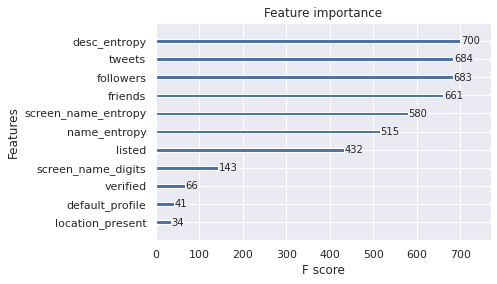

In [ ]:
from xgboost import plot_importance
f = 'gain'
xgb.get_booster().get_score(importance_type= f)
plot_importance(xgb)
print(xgb.feature_importances_)